# Summarize Void Growth and Movement
Determine whether time or size affect the mobility or growth rates of voids.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colormaps
from scipy.optimize import minimize
from scipy.stats import norm
from pathlib import Path
import pandas as pd
import numpy as np
import json

Configuration

In [2]:
run_directory = '../data/8bitTIFF-video26-575C/'

Other key paths

In [3]:
run_directory = Path(run_directory)
run_name = run_directory.name
out_directory = Path('output') / run_name

## Load the Smoothed Tracks
We are going to start from the tasks after smoothing them with splines

In [4]:
track_data = pd.read_csv(out_directory / 'smoothed_tracks.csv')
print(f'Loaded {len(track_data)} records from {len(track_data["void"].value_counts())} voids')

Loaded 12195 records from 77 voids


In [5]:
track_data.head()

,void,frame,radius,radius_dt,velocity_mag,position-x,position-y,color
0,26,126,2.503969,0.007560,0.034256,313.609368,218.656808,[0.119738 0.603785 0.5414 1. ]
1,7,389,9.625103,0.000658,0.000231,112.562256,333.006927,[0.150476 0.504369 0.55743 1. ]
2,6,486,7.301235,-0.000527,0.056309,194.790517,298.111739,[0.235526 0.309527 0.542944 1. ]
3,4,11,7.367107,-0.005753,0.010043,44.507430,215.794818,[0.647257 0.8584 0.209861 1. ]
4,2,585,4.992699,-0.010310,0.010121,123.120728,155.856934,[0.174274 0.445044 0.557792 1. ]


## Detect Outliners
See if any of the growth rates are particularly unlikely compared to the others. We are going to use methods based on the IQR for simplicity's sake

### Growth
From the previous notebook, we can see that growth terms are relatively smooth. So, I'm leery to refer to points as outliers unless they are far out

In [6]:
iqr_rdt = np.diff(np.percentile(track_data['radius_dt'], [25, 75]))[0]

In [7]:
k = 5  # Based on https://aakinshin.net/posts/tukey-outlier-probability/
upper_thr = np.percentile(track_data['radius_dt'], 75) + k * iqr_rdt
lower_thr = np.percentile(track_data['radius_dt'], 25) - k * iqr_rdt

Text(0, 0.5, 'Count')

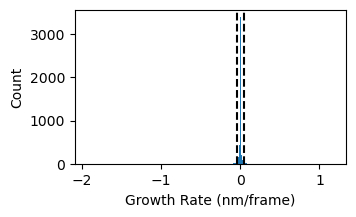

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.hist(track_data['radius_dt'], bins=1024)

ax.set_ylim(ax.get_ylim())
for thr in [lower_thr, upper_thr]:
    ax.plot([thr]*2, ax.get_ylim(), 'k--')

ax.set_xlabel('Growth Rate (nm/frame)')
ax.set_ylabel('Count')

In [9]:
track_data['growth_outlier'] = np.logical_or(track_data['radius_dt'] > upper_thr, track_data['radius_dt'] < lower_thr)
print(f'Found {track_data["growth_outlier"].sum()} outliers')

Found 601 outliers


### Movement
Movement is more jittery but I need to be less aggressive on movement rates because most voids are sessile. Only the rare void moves

In [10]:
iqr_rdt = np.diff(np.percentile(track_data['velocity_mag'], [25, 75]))[0]

In [11]:
k = 8  # Based on https://aakinshin.net/posts/tukey-outlier-probability/
upper_thr = np.percentile(track_data['velocity_mag'], 75) + k * iqr_rdt
lower_thr = np.percentile(track_data['velocity_mag'], 25) - k * iqr_rdt
print(f'Bounds for movement: {upper_thr:.3f}, {lower_thr:.3f}')

Bounds for movement: 0.338, -0.296


Text(0, 0.5, 'Count')

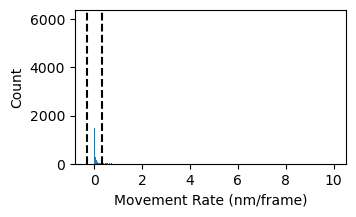

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.hist(track_data['velocity_mag'], bins=1024)

ax.set_ylim(ax.get_ylim())
for thr in [lower_thr, upper_thr]:
    ax.plot([thr]*2, ax.get_ylim(), 'k--')

ax.set_xlabel('Movement Rate (nm/frame)')
ax.set_ylabel('Count')

In [13]:
track_data['movement_outlier'] = np.logical_or(track_data['velocity_mag'] > upper_thr, track_data['velocity_mag'] < lower_thr)
print(f'Found {track_data["movement_outlier"].sum()} outliers')

Found 874 outliers


### Drop outliers
Exclude if it is an outlier for either

In [14]:
old_size = len(track_data)
track_data.query('not (movement_outlier or growth_outlier)', inplace=True)
print(f'New size: {len(track_data)}. {len(track_data) / old_size * 100:.2f}% passed.')

New size: 10925. 89.59% passed.


## Re-plot the void tracks
Drop the first and last 5 frames of the void track. Those are right where the void moved or changed enough that it 

Assign a random color to each void

In [15]:
cmap = colormaps['nipy_spectral']

In [16]:
colors = np.linspace(0, 1, len(track_data['void'].value_counts()))
rng = np.random.RandomState(1)
rng.shuffle(colors)
colors = cmap(colors)

In [17]:
known_voids = sorted(set(track_data['void']))
track_data['color'] = track_data['void'].apply(known_voids.index).apply(colors.__getitem__)

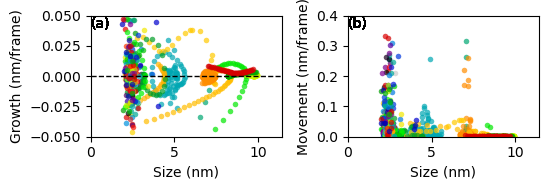

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), sharex=True)

alpha = 0.7

# Plot the growth
ax = axs[0]
for gid, group in track_data.groupby('void'):
    ax.text(0, 0.9, '(a)', transform=ax.transAxes, fontsize=10, weight='normal')
    group = group.sort_values('frame')
    
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['radius_dt'], 'o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_xlim(0, max(ax.get_xlim()) * 1.1)
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1)
ax.set_ylabel('Growth (nm/frame)')
ax.set_ylim(-0.05, 0.05)

# Plot the movement
ax = axs[1]
for gid, group in track_data.groupby('void'):
    ax.text(0, 0.9, '(b)', transform=ax.transAxes, fontsize=10, weight='normal')
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['velocity_mag'], 'o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_ylim(0, 0.4)
ax.set_ylabel('Movement (nm/frame)')

for ax in axs:
    ax.set_xlabel('Size (nm)')
fig.tight_layout()
fig.savefig(out_directory / 'figures/time-resolved-voids-by-size.png', dpi=320)

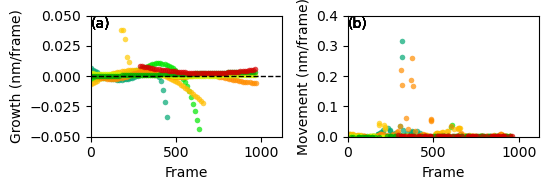

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), sharex=True)

alpha = 0.7

# Plot the growth
ax = axs[0]
for gid, group in track_data.query('radius > 6').groupby('void'):
    ax.text(0, 0.9, '(a)', transform=ax.transAxes, fontsize=10, weight='normal')
    group = group.sort_values('frame')
    
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['frame'], group['radius_dt'], 'o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_xlim(0, max(ax.get_xlim()) * 1.1)
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1)
ax.set_ylabel('Growth (nm/frame)')
ax.set_ylim(-0.05, 0.05)

# Plot the movement
ax = axs[1]
for gid, group in track_data.query('radius > 6').groupby('void'):
    ax.text(0, 0.9, '(b)', transform=ax.transAxes, fontsize=10, weight='normal')
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['frame'], group['velocity_mag'], 'o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_ylim(0, 0.4)
ax.set_ylabel('Movement (nm/frame)')

for ax in axs:
    ax.set_xlabel('Frame')
fig.tight_layout()
fig.savefig(out_directory / 'figures/time-resolved-voids-by-time.png', dpi=320)

## Fit a model for void growth and movement
We can assume that both the mean and variance of growth rate for a void is a function of size.

$\dot{r} \sim t(\alpha_0 + \alpha_1 r, 10^{\beta_0 + \beta_1 r})$

We fit this distribution my minimizing the log-likelihood of the observed data, which are pairs of $r$ and $\dot{r}$.

Similar logic holds for

In [20]:
def get_size_distribution(r: float | np.ndarray, params: list[float]):
    """Get the expected growth rate distribution of a void given its size
    
    Args:
        radius: Sizes of the void
        params: Parameters for the distribution model.
            Ordered as [alpha, beta]
    Returns:
        Distribution for all voids
    """
    return norm(params[0] + params[1] * r, np.power(10, params[2] + params[3] * r))

Fit the model

In [21]:
def loss_function(params: list[float], data: pd.DataFrame, target_column: str = 'radius_dt') -> float:
    """Compute the negative log loss of the data given a 
    model which explains the property being an effect of 
    radius.
    
    Args:
        params: Parameters for the distribution. We assume the parameters for the 
        data: Data of the void distribution
        target_column: Column being fit
    """
    
    r = data['radius']
    growth_dist = get_size_distribution(r, params)
    nll = growth_dist.logpdf(data[target_column])
    return -nll.sum()

In [22]:
result = minimize(loss_function, [0, 0, -1, 0], args=(track_data,))
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -35661.77034672131
        x: [-1.035e-03  2.514e-04 -1.535e+00 -8.919e-02]
      nit: 15
      jac: [-2.061e+00 -1.629e+01 -4.395e-03 -8.789e-02]
 hess_inv: [[ 8.693e-08 -1.029e-08 -1.842e-07  3.070e-08]
            [-1.029e-08  1.284e-09  2.264e-08 -3.707e-09]
            [-1.842e-07  2.264e-08  6.069e-05 -9.290e-06]
            [ 3.070e-08 -3.707e-09 -9.290e-06  1.672e-06]]
     nfev: 341
     njev: 66

In [23]:
growth_params = result.x
print(f'Void growth is defined by: {growth_params[0]:.2e} + {growth_params[1]:.2e} * r')

Void growth is defined by: -1.04e-03 + 2.51e-04 * r


Repeat for movement

In [24]:
track_data['log_velocity_mag'] = np.log(track_data['velocity_mag'])
result = minimize(loss_function, [-3, 0, 0, 0], args=(track_data, 'log_velocity_mag'))
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 16479.60325890333
        x: [-2.475e+00 -4.353e-01  1.013e-01 -1.116e-02]
      nit: 19
      jac: [ 0.000e+00 -2.441e-04 -2.441e-04  2.441e-04]
 hess_inv: [[ 2.193e-06 -3.547e-07  9.257e-06 -1.601e-06]
            [-3.547e-07  2.573e-06 -1.558e-06  2.753e-07]
            [ 9.257e-06 -1.558e-06  6.211e-05 -9.223e-06]
            [-1.601e-06  2.753e-07 -9.223e-06  1.595e-06]]
     nfev: 155
     njev: 31

In [25]:
movement_params = result.x
print(f'Log void movement is defined by: {movement_params[0]:.2e} + {movement_params[1]:.2e} * r')

Log void movement is defined by: -2.48e+00 + -4.35e-01 * r


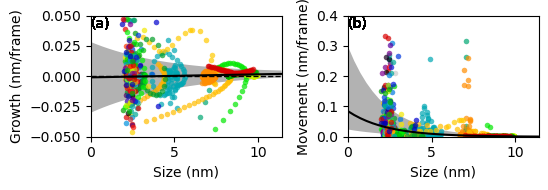

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), sharex=True)

alpha = 0.7

# Plot the growth
ax = axs[0]
for gid, group in track_data.groupby('void'):
    ax.text(0, 0.9, '(a)', transform=ax.transAxes, fontsize=10, weight='normal')
    group = group.sort_values('frame')
    
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['radius_dt'], 'o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_xlim(0, max(ax.get_xlim()) * 1.1)
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1)
ax.set_ylabel('Growth (nm/frame)')
ax.set_ylim(-0.05, 0.05)

steps = np.linspace(*ax.get_xlim(), 32)
mean = growth_params[0] + steps * growth_params[1]
std = np.power(10, growth_params[2] + growth_params[3] * steps)
ax.plot(steps, mean, 'k')
ax.fill_between(steps, mean + std, mean - std, alpha=0.3, color='k', edgecolor='none')

# Plot the movement
ax = axs[1]
for gid, group in track_data.groupby('void'):
    ax.text(0, 0.9, '(b)', transform=ax.transAxes, fontsize=10, weight='normal')
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['velocity_mag'], 'o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_ylim(0, 0.4)
ax.set_ylabel('Movement (nm/frame)')

steps = np.linspace(*ax.get_xlim(), 32)
mean = movement_params[0] + steps * movement_params[1]
std = np.power(10, movement_params[2] + movement_params[3] * steps)
ax.plot(steps, np.exp(mean), 'k')
ax.fill_between(steps, np.exp(mean + std), np.exp(mean - std), alpha=0.3, color='k', edgecolor='none')


for ax in axs:
    ax.set_xlabel('Size (nm)')
fig.tight_layout()
fig.savefig(out_directory / 'figures/time-resolved-voids-by-size.png', dpi=320)

Save the model parameters

In [29]:
with (out_directory / 'model-parameters.json').open('w') as fp:
    json.dump({
        'growth': growth_params.tolist(),
        'movement': movement_params.tolist()
    }, fp)